In [2]:
import scanpy as sc
import numpy as npyeah
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scRNAseq_utils import *
import os
import anndata
import collections

from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

# Read in Cellranger ARC output

Read in the `filtered_feature_bc_matrix.h5` for each sample wherever you stored it.

Read in single-cell mito coverages per base pair. We have uploaded to counts already, but to generate them from scratch, run `notebooks/GlucoseGalactoseExp/GlucoseGalactoseExp_process_mito_fragments.ipynb`.

Given the single-cell mito coverages, we can then:
- Estimate heteroplasmy for each single-cell
- Filter our cells with average coverage below 20

In [32]:
def compute_heteroplasmy(count_df):
    mito_len = 16569
    start = mito_len - 8556
    end = mito_len - 5109

    # originally 1396 - 4514 (FISH_PROBE REGION), adjusted to be same length as del region
    common_start = 1231
    common_end = 4678 
    common_end - common_start

    del_counts = count_df[[str(x) for x in range(start - 1, end)]].sum(axis = 1)
    common_counts = count_df[[str(x) for x in range(common_start - 1, common_end)]].sum(axis = 1)

    heteroplasmy = del_counts/common_counts
    heteroplasmy.loc[heteroplasmy > 1] = 1

    heteroplasmy = 1 - heteroplasmy
    
    return heteroplasmy

def annotate_heteroplasmy(adata):
    temp = []
    for x in adata.obs['heteroplasmy_score']:
        if x < 0.05:
            temp.append('Wt')
        elif x < 0.3:
            temp.append('Low')
        elif x < 0.65:
            temp.append('Medium')
        else:
            temp.append('High')

    adata.obs['heteroplasmy'] = temp
    return adata

In [28]:
samples = ['Galactose', 'Glucose+Pyruvate', 'Glucose-Pyruvate']

In [2]:
data_dir = '/data/peer/landm/Projects/sail-dogma/yi-clone-samples/data/'

adatas = []
for s in samples:
    count_df = pd.read_csv(f"../../misc/mito_coverages/{s}_sc_mito_cov.csv", index_col = 0)
    before = count_df.shape[0]
    count_df = count_df[count_df.mean(axis = 1) >= 20]
    print(f"Removing {before - count_df.shape[0]} cells with avg coverage below 20.")
    heteroplasmy = compute_heteroplasmy(count_df)
    
    # file path NOT stored on repo, download from GEO and change path accordingly
    adata = sc.read_10x_h5(f'{data_dir}{s}/cr-arc-results/filtered_feature_bc_matrix.h5')
    adata.var_names_make_unique()
    shared_barcodes = list(set(count_df.index).intersection(set(adata.obs_names)))
    print(f"Got rid of {adata.shape[0] - len(shared_barcodes)} cells.")
    adata = adata[shared_barcodes, :]
    adata.obs['heteroplasmy_score'] = heteroplasmy.loc[shared_barcodes]
    adata.obs['sample'] = s
    adatas.append(adata)

/home/landm/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/landm/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/landm/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/landm/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/landm/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: Use

In [ ]:
sample_to_short_dict2 =  {
    "YF-2721_48mix_25dGlu_3d_mito_hLLLdogma_multiome": 'Glucose',
    "YF-2721_48mix_10dGal_3d_mito_hLLLdogma_multiome": 'Galactose',
    "YF-2721_48mix_25dGlu_NoPyr_3d_mito_hLLLdogma_multiome": 'Glucose_No_Pyr',
}

for i in range(len(adatas)):
    prefix = sample_to_short_dict2[np.unique(adatas[i].obs['sample_full_name'])[0]]
    adatas[i].obs_names = [prefix + '#' + x for x in adatas[i].obs_names]

In [ ]:
adata = sc.concat(adatas, axis = 0)
# adata.write_h5ad(f'{rna_analysis_dir}adata_raw_filt_cov.h5ad')

# Processing on 4500 HVGs and 30pcs (filter out low quality cells)

In [5]:
# relative dir path, adata already filtered for at least 20 average mito coverage.
raw_filt_cov_path = '../../misc/adatas/adata_raw_filt_cov.h5ad'
adata = sc.read_h5ad(raw_filt_cov_path)

In [7]:
sample_cpal = dict(zip(['Galactose', 'Glucose+Pyruvate', 'Glucose-No Pyruvate'], sns.color_palette()))

In [8]:
adata = preprocessing(adata, n_hvgs = 4500, n_pcs = 30)

/home/landm/anaconda3/envs/scanpy/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/landm/anaconda3/envs/scanpy/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/landm/anaconda3/envs/scanpy/lib/python3.8/site-packages/umap/distanc

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 10.930017232894897 seconds
Jaccard graph constructed in 5.598383903503418 seconds
Wrote graph to binary file in 0.4445943832397461 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.7895
After 3 runs, maximum modularity is Q = 0.790715
After 14 runs, maximum modularity is Q = 0.792296
After 31 runs, maximum modularity is Q = 0.794491
Louvain completed 51 runs in 40.738391637802124 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 60.07693147659302 seconds


In [9]:
# file contains list of human ribosomal genes
adata = qc_metrics(adata, path_RB= "../../misc/RB_genes_human")

/lila/data/peer/landm/Projects/sail-dogma/yi-clone-samples/github-repo/notebooks/GlucoseGalactoseExp/scRNAseq_utils.py:8: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mito'] = mito_genes


In [10]:
sc.tl.leiden(adata, resolution = 0.1)

/home/landm/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/landm/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


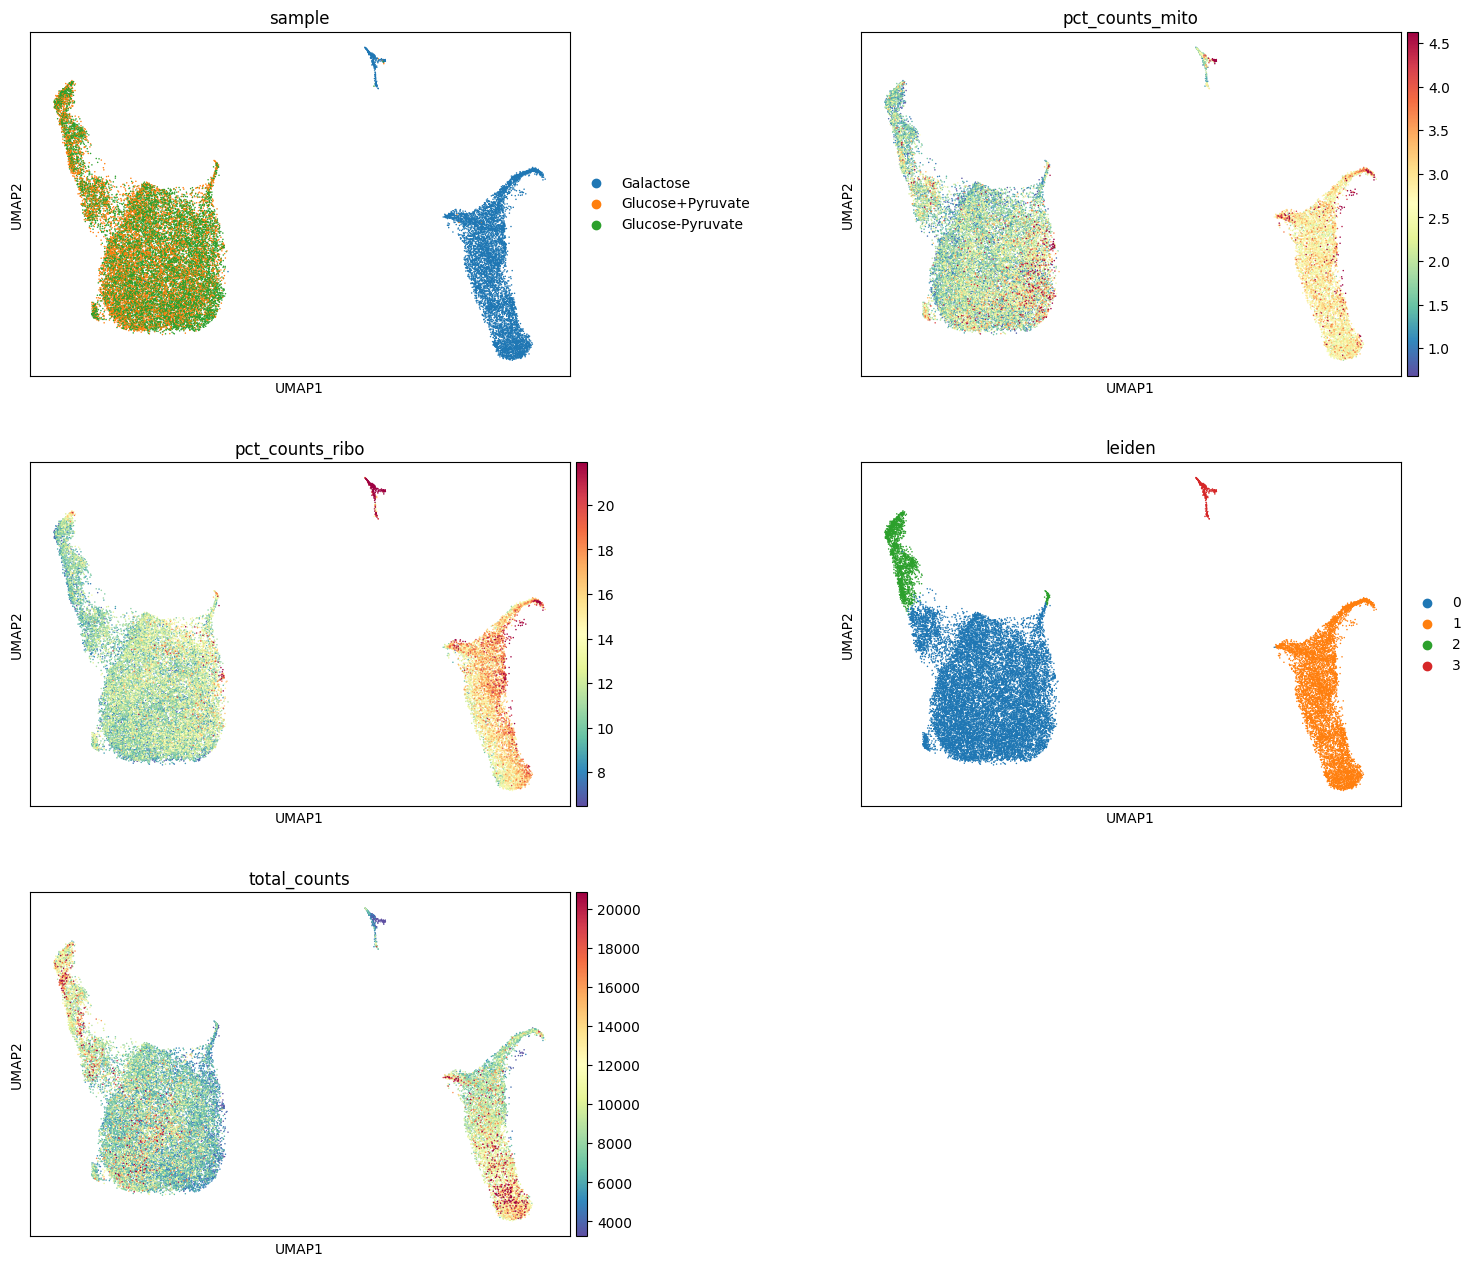

In [11]:
sc.pl.umap(adata, color = ['sample',
                           'pct_counts_mito', 'pct_counts_ribo', 'leiden', 'total_counts'],
          vmin = 'p1',
          vmax = 'p99',
          cmap = 'Spectral_r',
          wspace = 0.4,
          ncols = 2)

### Cluster 3 has high ribosomal counts and low total counts, remove as low quality.

In [12]:
adata_filt = adata[adata.obs.leiden != '3']

In [43]:
adata_filt = annotate_heteroplasmy(adata_filt)
# adata_filt.write_h5ad('../../misc/adatas/adata_4500_hvg_processed.h5ad')

### Figure S6c

/home/landm/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


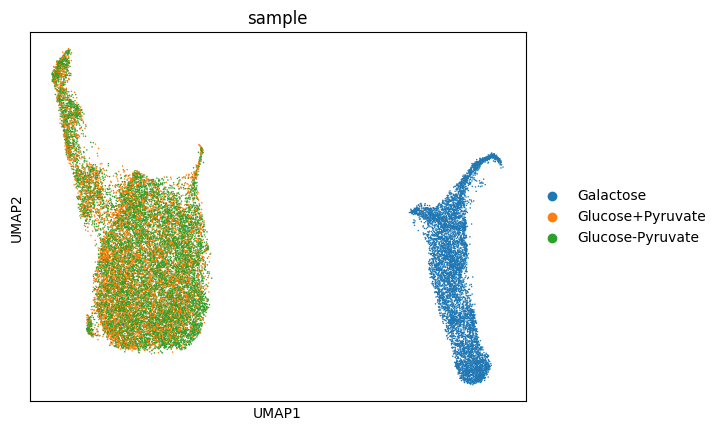

In [13]:
sc.pl.umap(adata_filt, color = 'sample')

# Explore heteroplasmy distribution across samples

In [18]:
sample_cpal = dict(zip(['Galactose', 'Glucose+Pyruvate', 'Glucose-Pyruvate'], sns.color_palette()))

### Figure 3b

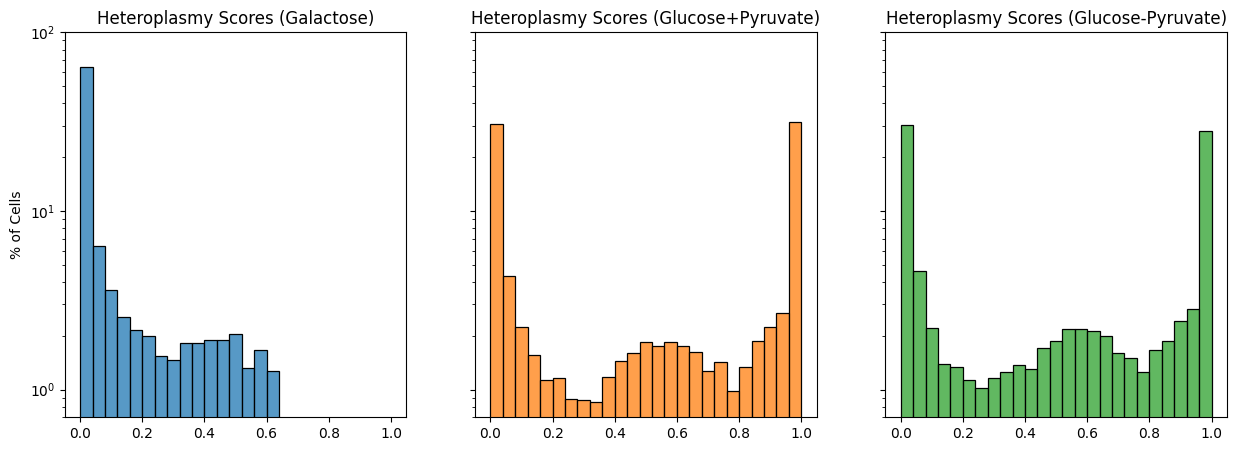

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharex =True, 
                        sharey = True
                       )


for ax, s in zip(axs.reshape(-1), np.unique(adata_filt.obs['sample'])):
    idx = adata_filt.obs['sample'] == s
    g = sns.histplot(adata_filt[idx, :].obs['heteroplasmy_score'].values, bins = np.linspace(0, 1, 26),
                      color = sample_cpal[s], ax = ax, stat = 'percent',  )
    g.set(title = f'Heteroplasmy Scores ({s})', ylabel = '% of Cells', ylim = (0.7, 100))
    # g.set_yscale("log")
plt.yscale('log')
# plt.savefig(f'{fig_dir}heteroplasmy_%_same_y_scale.svg', dpi = 300, bbox_inches = 'tight')
plt.show()

### Figure S7b

In [38]:
data = []

for s in np.unique(adata_filt.obs['sample']):
    idx = adata_filt.obs['sample'] == s
    size = adata_filt[idx, :].shape[0]
    temp = pd.DataFrame(collections.Counter(adata_filt[idx, :].obs['heteroplasmy']).items(), 
                       columns = ['heteroplasmy', 'count'])
    temp.index = temp['heteroplasmy'].values
    temp = temp.loc[['Wt', 'Low', 'Medium', 'High']]
    temp['sample'] = s
    temp['percent'] = temp['count']*100/size
    data.append(temp)
data = pd.concat(data)

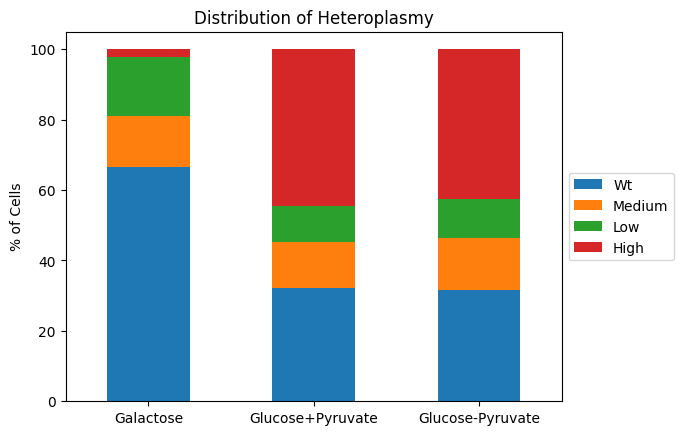

In [41]:
pct_df = data.pivot(index= 'sample', columns = 'heteroplasmy')['percent']
pct_df  = pct_df[pct_df.columns[::-1]]
ax = pct_df.plot(kind='bar', stacked=True, color=cpal.values())
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel = None, ylabel = '% of Cells', title = 'Distribution of Heteroplasmy',)
ticks = plt.xticks(rotation = 0)

# Figure S6a

In [20]:
samples = ['Galactose', 'Glucose+Pyruvate', 'Glucose-Pyruvate']
cpal = dict(zip(['Wt', 'Low', 'Medium', 'High'], sns.color_palette()))

In [31]:
count_dfs = {}
for s in samples:
    count_df = pd.read_csv(f"../../misc/mito_coverages/{s}_sc_mito_cov.csv", index_col = 0)
    count_dfs[s] = count_df

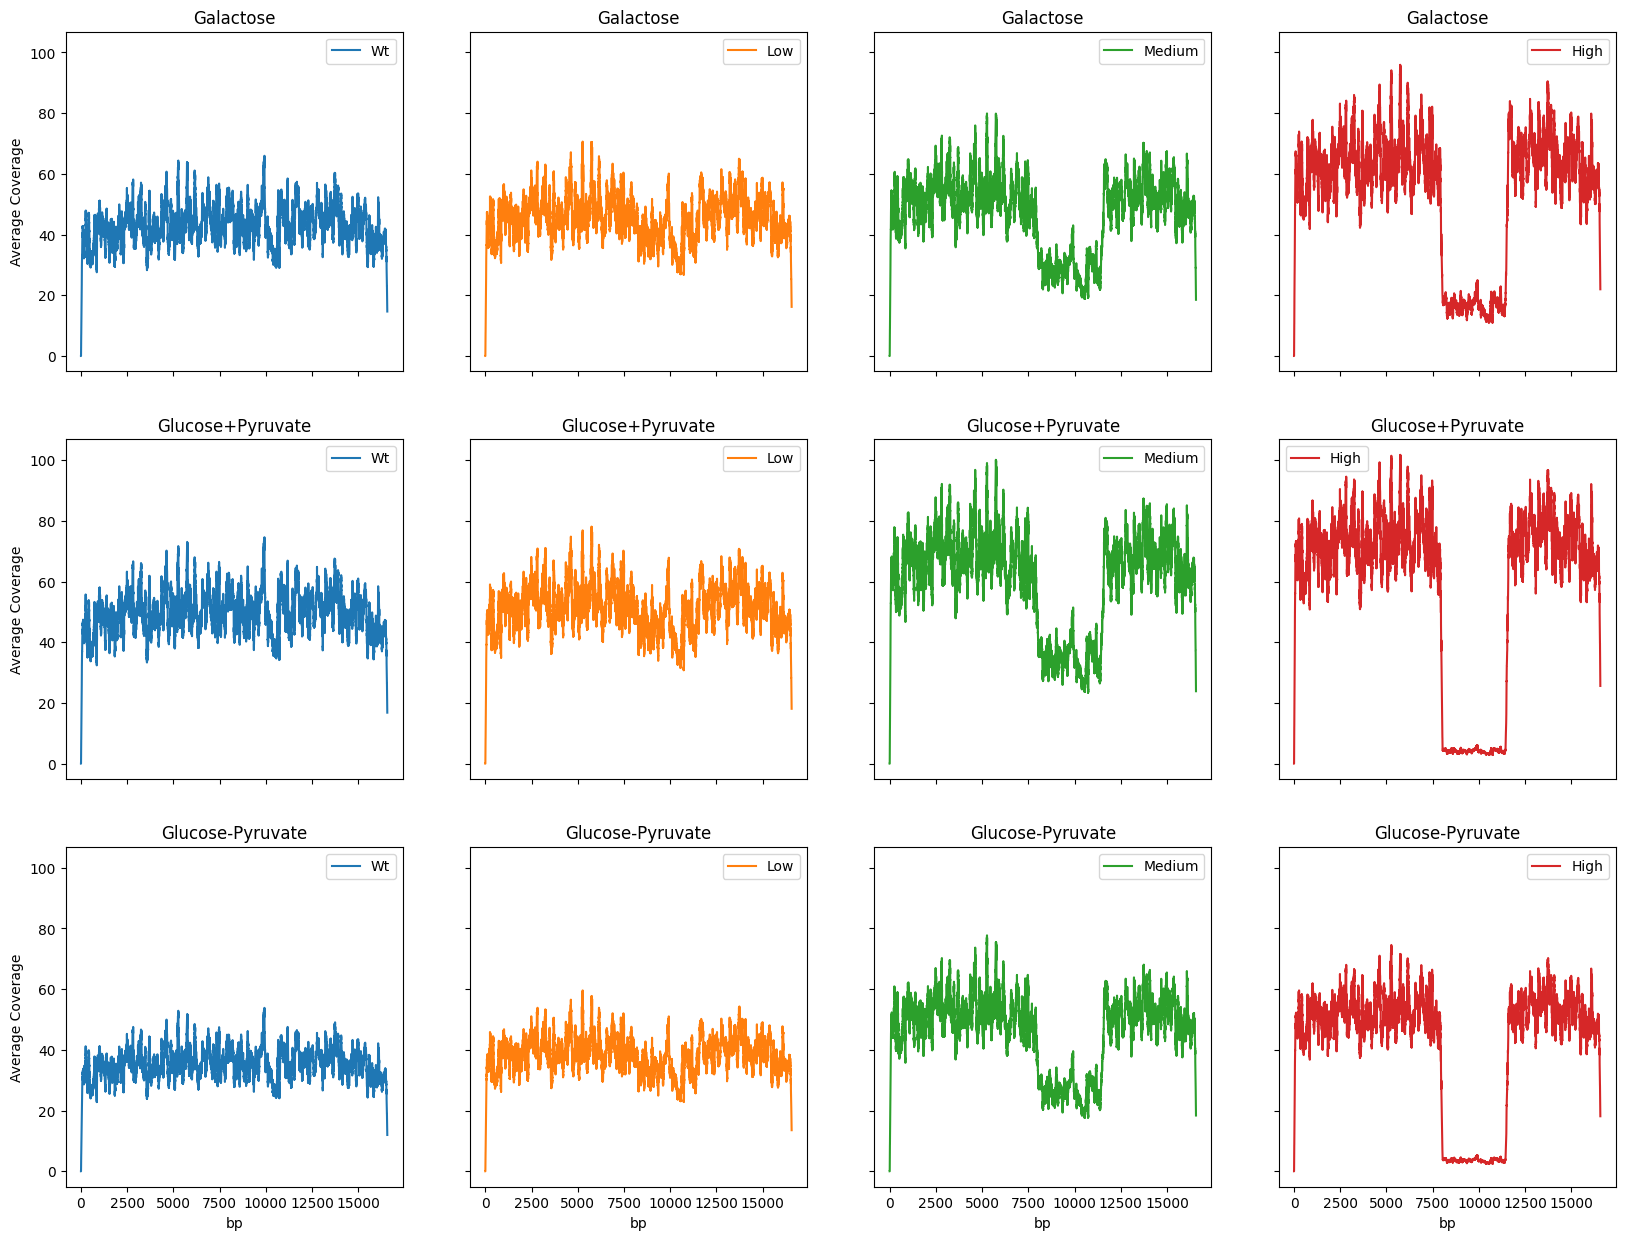

In [37]:
fig, axs = plt.subplots(3, 4, figsize=(20,15), sharex =True, 
                        sharey = True
                       )

temp_samples = np.array([[s]*4 for s in samples]).flatten()
categories = ['Wt', 'Low', 'Medium', 'High']*4
for ax, s, cat in zip(axs.reshape(-1), temp_samples, categories):
    idx = adata_filt.obs['sample'] == s
    adata_temp = adata_filt[idx, :]
    idx2 = adata_temp.obs['heteroplasmy'] == cat
    barcodes = [x.split('#')[1] for x in adata_temp[idx2, :].obs_names]
    cov = pd.DataFrame([count_dfs[s].loc[barcodes].columns, count_dfs[s].loc[barcodes].mean()] , index = ['bp', 'count_norm']).T
    cov['bp'] = cov['bp'].astype(int)
    cov['count_norm'] = cov['count_norm'].astype(float)
    
    ax = sns.lineplot(x=cov['bp'], y=cov['count_norm'], label = cat,
              ax=ax, color = cpal[cat])
    ax.set(ylabel = 'Average Coverage', title = s)
    # ax.get_legend().remove()
    
# plt.savefig(f'{fig_dir}all_samples_by_heteroplasmy_category_coverage_plots.svg', dpi = 300, bbox_inches = 'tight')
plt.show()

# Process each sample with 4500 HVGs, 30 PCs

In [42]:
adatas = {}

for s in np.unique(adata_filt.obs['sample']):
    idx = adata_filt.obs['sample'] == s
    temp_adata = sc.AnnData(X = adata_filt[idx, :].layers['raw_counts'],
                            obs = adata_filt[idx, :].obs[['sample_full_name', 'sample', 'heteroplasmy', 'heteroplasmy_score']])
    temp_adata.var_names = adata_filt[idx,:].var_names
    temp_adata = preprocessing(temp_adata, n_hvgs = 4500, n_pcs = 30)
    temp_adata = qc_metrics(temp_adata, path_RB= "/data/peer/landm/Projects/sawyer-lab/RB_genes_human")
    
    temp_adata = annotate_heteroplasmy(temp_adata)

    temp_adata.uns['log1p']['base'] = None
    sc.tl.rank_genes_groups(temp_adata, 'heteroplasmy', reference = 'Wt', method = 'wilcoxon',)
    adatas[s] = temp_adata
    # temp_adata.write_h5ad(f'../../misc/adatas/per_sample_processed/adata_{s}.h5ad')

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2984247207641602 seconds
Jaccard graph constructed in 7.580198526382446 seconds
Wrote graph to binary file in 0.10376763343811035 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.719098
Louvain completed 21 runs in 7.361769199371338 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 22.539124488830566 seconds


/lila/data/peer/landm/Projects/sail-dogma/yi-clone-samples/github-repo/notebooks/GlucoseGalactoseExp/scRNAseq_utils.py:8: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mito'] = mito_genes


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8912904262542725 seconds
Jaccard graph constructed in 7.346114635467529 seconds
Wrote graph to binary file in 0.11556816101074219 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.682547
After 2 runs, maximum modularity is Q = 0.688698
After 6 runs, maximum modularity is Q = 0.691891
Louvain completed 26 runs in 12.250687837600708 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 27.942081451416016 seconds


/lila/data/peer/landm/Projects/sail-dogma/yi-clone-samples/github-repo/notebooks/GlucoseGalactoseExp/scRNAseq_utils.py:8: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mito'] = mito_genes


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 3.9946112632751465 seconds
Jaccard graph constructed in 7.674004077911377 seconds
Wrote graph to binary file in 0.15839362144470215 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.685565
After 2 runs, maximum modularity is Q = 0.688886
After 7 runs, maximum modularity is Q = 0.69168
Louvain completed 27 runs in 15.694873094558716 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 33.55013656616211 seconds


/lila/data/peer/landm/Projects/sail-dogma/yi-clone-samples/github-repo/notebooks/GlucoseGalactoseExp/scRNAseq_utils.py:8: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mito'] = mito_genes


## Compute DEGs between heteroplasmy levels within each sample

We compute DEGs for Low vs Zero/Wt, Medium vs Zero/Wt, High vs Zero/Wt for each sample.

In [ ]:
adatas = {}
with pd.ExcelWriter('heteroplasmy_vs_zero_degs_all_samples.xlsx', engine='xlsxwriter') as writer:
    for s in samples:
        for cat in ['Low', 'Medium', 'High']:
            df = sc.get.rank_genes_groups_df(adatas[s], cat)
            if s == 'Glucose + No Pyruvate':
                # df.to_csv(f'{rna_analysis_dir}deg_results/within_sample/glu-pyr_{cat}_vs_zero.csv')
                df.to_excel(writer, sheet_name=f'glu-pyr_{cat}_vs_zero', index=False)
            elif s == 'Glucose':
                # df.to_csv(f'{rna_analysis_dir}deg_results/within_sample/glu+pyr_{cat}_vs_zero.csv')
                df.to_excel(writer, sheet_name=f'glu+pyr_{cat}_vs_zero', index=False)
            else:
                # df.to_csv(f'{rna_analysis_dir}deg_results/within_sample/{s}_{cat}_vs_zero.csv')
                df.to_excel(writer, sheet_name=f'{s}_{cat}_vs_zero', index=False)

# Processing on only mtRNA

Next, indepedently, we also reprocess our cells and compute similarity/visualization using only the mitochondrial RNA genes as features to see the effect of mitochondrial deletion on mtRNA expression.

In [4]:
adata_raw = sc.read_h5ad('../../misc/adatas/adata_raw_filt_cov.h5ad')

In [7]:
# Assuming adata is filtered to only mito genes, thus we skip HVG

def preprocessing_mt_genes(adata):
    # Normalize
    adata.layers['raw_counts'] = adata.X
    adata.layers['median'] = adata.layers['raw_counts'].copy()
    sc.pp.normalize_total(adata, layer='median')
    adata.layers['log'] = adata.layers['median'].copy()
    sc.pp.log1p(adata, layer='log')
    adata.X = adata.layers['log']
    sc.tl.pca(adata)
    adata.obsm['X_pca'] = adata.obsm['X_pca'].copy()

    # UMAP
    sc.pp.neighbors(adata, method='umap', n_neighbors = 30, use_rep='X_pca')
    sc.tl.umap(adata, min_dist = 0.1, random_state=5)
    
    # randomly shuffle indexes
    barcodes = list(adata.obs_names)
    random.shuffle(barcodes)
    adata = adata[barcodes, :]
    return adata

def qc_metrics_mt_genes(adata):
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.var['mito'] = mito_genes
    mito_genes = np.array(adata.var.index)[mito_genes]
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=('mito',), inplace=True, layer='raw_counts')
    
    return adata

In [8]:
mt_genes = [x for x in adata_raw.var_names if x.startswith('MT-')]
adata_mt = adata_raw[:, mt_genes]

In [9]:
adata_mt = preprocessing_mt_genes(adata_mt)

/home/landm/anaconda3/envs/scanpy/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/landm/anaconda3/envs/scanpy/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/landm/anaconda3/envs/scanpy/lib/python3.8/site-packages/umap/distanc

## Figures 3d, 3e

/home/landm/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/landm/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


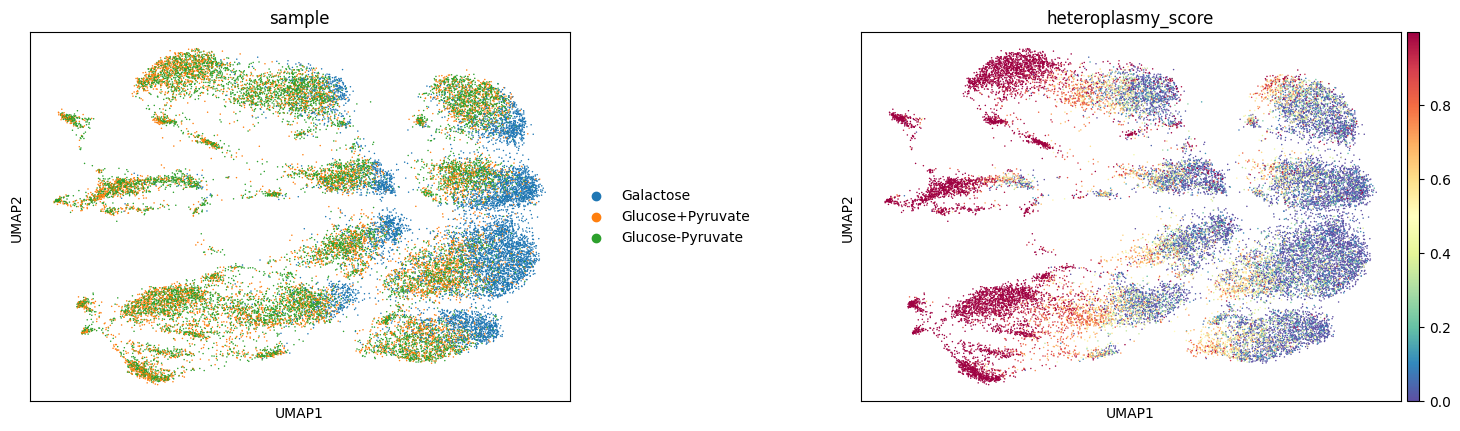

In [10]:
sc.pl.umap(adata_mt, color = ['sample', 'heteroplasmy_score', ],
          vmin = 'p1',
          vmax = 'p99',
          cmap = 'Spectral_r',
          wspace = 0.4,
          ncols = 2)

# Running MAGIC imputation on each sample

We run MAGIC computed on the nearest neighbor graph based on mtRNA gene expression since it correlates well with heteroplasmy, and we want to impute across genes with similar heteroplasmy.

In [18]:
import pandas as pd
import numpy as np
import phenograph

from scipy.sparse import csr_matrix, find, issparse
from scipy.sparse.linalg import eigs
import scanpy as sc

def run_diffusion_maps(data_df, n_components=10, knn=30, alpha=0):
    """Run Diffusion maps using the adaptive anisotropic kernel
    :param data_df: PCA projections of the data or adjacency matrix
    :param n_components: Number of diffusion components
    :param knn: Number of nearest neighbors for graph construction
    :param alpha: Normalization parameter for the diffusion operator
    :return: Diffusion components, corresponding eigen values and the diffusion operator
    """

    # Determine the kernel
    N = data_df.shape[0]
    if not issparse(data_df):
        print("Determing nearest neighbor graph...")
        temp = sc.AnnData(data_df.values)
        sc.pp.neighbors(temp, n_pcs=0, n_neighbors=knn)
        kNN = temp.obsp['distances']

        # Adaptive k
        adaptive_k = int(np.floor(knn / 3))
        adaptive_std = np.zeros(N)

        for i in np.arange(len(adaptive_std)):
            adaptive_std[i] = np.sort(kNN.data[kNN.indptr[i] : kNN.indptr[i + 1]])[
                adaptive_k - 1
            ]

        # Kernel
        x, y, dists = find(kNN)

        # X, y specific stds
        dists = dists / adaptive_std[x]
        W = csr_matrix((np.exp(-dists), (x, y)), shape=[N, N])
        W.setdiag(1)
        
        # Diffusion components
        kernel = W + W.T
    else:
        kernel = data_df

    # Markov
    D = np.ravel(kernel.sum(axis=1))

    if alpha > 0:
        # L_alpha
        D[D != 0] = D[D != 0] ** (-alpha)
        mat = csr_matrix((D, (range(N), range(N))), shape=[N, N])
        kernel = mat.dot(kernel).dot(mat)
        D = np.ravel(kernel.sum(axis=1))

    D[D != 0] = 1 / D[D != 0]
    T = csr_matrix((D, (range(N), range(N))), shape=[N, N]).dot(kernel)
    # Eigen value dcomposition
    D, V = eigs(T, n_components, tol=1e-4, maxiter=1000)
    D = np.real(D)
    V = np.real(V)
    inds = np.argsort(D)[::-1]
    D = D[inds]
    V = V[:, inds]

    # Normalize
    for i in range(V.shape[1]):
        V[:, i] = V[:, i] / np.linalg.norm(V[:, i])

    # Create are results dictionary
    res = {"T": T, "EigenVectors": V, "EigenValues": D}
    res["EigenVectors"] = pd.DataFrame(res["EigenVectors"])
    if not issparse(data_df):
        res["EigenVectors"].index = data_df.index
    res["EigenValues"] = pd.Series(res["EigenValues"])
    res["kernel"] = kernel

    return res


def run_magic_imputation(data, dm_res, n_steps=3):
    """Run MAGIC imputation
    :param dm_res: Diffusion map results from run_diffusion_maps
    :param n_steps: Number of steps in the diffusion operator
    :return: Imputed data matrix
    """
    if type(data) is sc.AnnData:
        data = pd.DataFrame(data.X.todense(), index=data.obs_names, columns=data.var_names)

    imputed_data = data
    for j in range(n_steps):
        imputed_data = dm_res['T'] * imputed_data
        
        
        #T_steps = dm_res["T"] ** n_steps
        #imputed_data = pd.DataFrame(
        #np.dot(T_steps.todense(), data), index=data.index, columns=data.columns)

    return imputed_data

In [14]:
# Compute PCA and hence nearest neighbors based on specific set of genes

def preprocessing_specific_genes(adata, geneset, n_comps = 30):
    # Normalize
    adata.layers['raw_counts'] = adata.X
    adata.layers['median'] = adata.layers['raw_counts'].copy()
    sc.pp.normalize_total(adata, layer='median')
    adata.layers['log'] = adata.layers['median'].copy()
    sc.pp.log1p(adata, layer='log')
    adata.X = adata.layers['log']
    adata.obsm['X_pca'] = sc.tl.pca(adata[:, geneset].X, n_comps = n_comps)

    # UMAP
    sc.pp.neighbors(adata, method='umap', n_neighbors = 30, use_rep='X_pca')
    sc.tl.umap(adata, min_dist = 0.1, random_state=5)
    
    return adata

In [21]:
processed_dir = '../../misc/adatas/per_sample_processed/'
magic_dir = '../../misc/adatas/per_sample_magic_processed/'

Glucose-Pyruvate


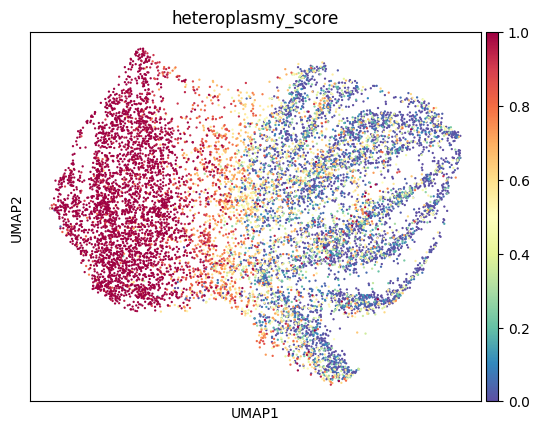

Determing nearest neighbor graph...


/home/landm/anaconda3/envs/scanpy/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [22]:
adatas = {}
pearson_dfs = {}

for s in ['Galactose', 'Glucose+Pyruvate', 'Glucose-Pyruvate']:
    print(s)
    adatas[s] = sc.read_h5ad(f'{processed_dir}adata_{s}.h5ad')
    random.seed(10)
    adata = adatas[s].copy()

    adata_new = sc.AnnData(adata.layers['raw_counts'])
    adata_new.obs_names = adata.obs_names
    adata_new.var_names = adata.var_names
    adata_new.obs = adata.obs[['sample', 'sample_full_name', 'heteroplasmy_score']]
    
    mt_genes = [x for x in adata.var_names if x.startswith('MT-')]

    adata_new = preprocessing_specific_genes(adata_new, mt_genes, n_comps = None)
    sc.pl.umap(adata_new, color = 'heteroplasmy_score', cmap = 'Spectral_r')

    data_df = pd.DataFrame(adata_new.obsm['X_pca'], index = adata_new.obs.index)
    res = run_diffusion_maps(data_df)

    adata_new.layers['magic_imputed'] = run_magic_imputation(adata_new, res)
    
    # adata_new.write_h5ad(f'{magic_dir}/adata_{s}.h5ad')